# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
from sympy.printing.pytorch import torch
from torch import nn
from pytorch_tcn import TCN 
import time
import cv2
import mediapipe as mp
import numpy as np
import os


In [ ]:
#from mmpose.apis import init_model, inference_topdown
#from mmpose.structures import merge_data_samples
#from mmpose.visualization import PoseLocalVisualizer

In [8]:
import cv2
import mediapipe as mp
import numpy as np
import os
import math

# -------------------------------
# Açı hesaplama fonksiyonu
# -------------------------------
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# -------------------------------
# MediaPipe Pose
# -------------------------------
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

SAVE_DIR = "squat_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)

VIDEO_DIR = "squat_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

# -------------------------------
# Video İşleme
# -------------------------------
for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            keypoints = []

            # 🔹 Tüm landmark koordinatları
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # =========================
            # SOL TARAF NOKTALARI
            # =========================
            L_SHOULDER = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            L_ELBOW    = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
            L_WRIST    = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
            L_HIP      = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            L_KNEE     = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
            L_ANKLE    = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]

            # =========================
            # SAĞ TARAF NOKTALARI
            # =========================
            R_SHOULDER = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
            R_ELBOW    = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW]
            R_WRIST    = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
            R_HIP      = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
            R_KNEE     = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
            R_ANKLE    = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]

            # =========================
            # SOL AÇILAR
            # =========================
            left_shoulder_angle = calculate_angle(
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z]
            )

            left_elbow_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_WRIST.x, L_WRIST.y, L_WRIST.z]
            )

            left_hip_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z]
            )

            left_knee_angle = calculate_angle(
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z],
                [L_ANKLE.x, L_ANKLE.y, L_ANKLE.z]
            )

            # =========================
            # SAĞ AÇILAR
            # =========================
            right_shoulder_angle = calculate_angle(
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z]
            )

            right_elbow_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_WRIST.x, R_WRIST.y, R_WRIST.z]
            )

            right_hip_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z]
            )

            right_knee_angle = calculate_angle(
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z],
                [R_ANKLE.x, R_ANKLE.y, R_ANKLE.z]
            )

            # 🔹 Açılar ekleniyor (SOL + SAĞ)
            keypoints.extend([
                left_shoulder_angle, left_elbow_angle, left_hip_angle, left_knee_angle,
                right_shoulder_angle, right_elbow_angle, right_hip_angle, right_knee_angle
            ])

            frames_data.append(keypoints)

    cap.release()

    # -------------------------------
    # Padding (200 frame)
    # -------------------------------
    if len(frames_data) < sequence_length:
        last_frame = frames_data[-1] if frames_data else [0] * len(frames_data[0])
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)

    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766875483.872445 6316384 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766875483.967402 6332254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766875483.992628 6332254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


IMG_6490.mp4 için veri kaydedildi -> squat_dataset/IMG_6490.npy
IMG_6491.mp4 için veri kaydedildi -> squat_dataset/IMG_6491.npy
IMG_6493.mp4 için veri kaydedildi -> squat_dataset/IMG_6493.npy
IMG_6492.mp4 için veri kaydedildi -> squat_dataset/IMG_6492.npy
IMG_6496.mp4 için veri kaydedildi -> squat_dataset/IMG_6496.npy
IMG_6497.mp4 için veri kaydedildi -> squat_dataset/IMG_6497.npy
IMG_6495.mp4 için veri kaydedildi -> squat_dataset/IMG_6495.npy
videoplayback-8.mp4 için veri kaydedildi -> squat_dataset/videoplayback-8.npy
IMG_6494.mp4 için veri kaydedildi -> squat_dataset/IMG_6494.npy
IMG_6168.mp4 için veri kaydedildi -> squat_dataset/IMG_6168.npy
IMG_6183.mp4 için veri kaydedildi -> squat_dataset/IMG_6183.npy
IMG_6182.mp4 için veri kaydedildi -> squat_dataset/IMG_6182.npy
IMG_6169.mp4 için veri kaydedildi -> squat_dataset/IMG_6169.npy
IMG_6180.mp4 için veri kaydedildi -> squat_dataset/IMG_6180.npy
IMG_6181.mp4 için veri kaydedildi -> squat_dataset/IMG_6181.npy
IMG_6185.mp4 için veri kay

In [9]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)


#BU CELL VİDEODAN ŞINAV DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "pushup_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "pushup_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]
            left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].z]

            # Açılar
            elbow_angel=calculate_angle(left_shoulder,left_elbow,left_hip)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)

            keypoints.extend([elbow_angel, knee_angle,])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #boş listeyse 102 tane 0 yaz değilse sonra frame ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1764002526.751690  749178 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1764002526.840519  785297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764002526.857952  785299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.48033455   0.82065254  -0.256515   ...   0.58623415  91.72430498
  178.02704238]
 [  0.48071387   0.82292145  -0.26389912 ...   0.52113825  85.94223449
  178.54080182]
 [  0.48073962   0.82369679  -0.26658288 ...   0.51038593  84.48316388
  178.79784792]
 ...
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]
 [  0.49918717   0.84481996  -0.27613062 ...   0.53693116  95.79998858
  175.75870548]]
IMG_6137.mp4 için veri kaydedildi -> pushup_dataset/IMG_6137.npy
Veri kaydedildi: [[ 4.55328077e-01  8.21577847e-01 -1.12824492e-01 ...  3.77014279e-01
   9.51068013e+01  1.76911253e+02]
 [ 4.53648061e-01  8.18992078e-01 -8.21425244e-02 ...  4.23187941e-01
   1.02282570e+02  1.74825184e+02]
 [ 4.52186584e-01  8.16274107e-01 -7.61361420e-02 ...  4.46985364e-01
   1.00741175e+02  1.74310512e+02]
 ...
 [ 4.59076345e-01  8.27935755e-01 -1.60411552e-01 ...

In [3]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "jumpingjack_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "jumpingjack_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302291.346590 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302291.456228 3367674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302291.477202 3367675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302291.520217 3367677 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Veri kaydedildi: [[ 2.87781447e-01  4.52091426e-01 -1.46413535e-01 ...  1.29710303e+02
   1.38937931e+02  8.11575385e+01]
 [ 2.92657167e-01  4.49336350e-01 -1.68035254e-01 ...  1.30576295e+02
   1.36532442e+02  8.48514500e+01]
 [ 2.99057513e-01  4.48729724e-01 -1.77278265e-01 ...  1.31665298e+02
   1.32334590e+02  7.87874324e+01]
 ...
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]
 [ 2.42563814e-01  5.12554348e-01 -1.60567209e-01 ...  1.40787973e+02
   1.62384611e+02  8.40132744e+01]]
IMG_6335.mp4 için veri kaydedildi -> jumpingjack_dataset/IMG_6335.npy
Veri kaydedildi: [[ 3.02935958e-01  4.26879138e-01 -2.37338603e-01 ...  1.38091229e+02
   1.35735526e+02  8.16179817e+01]
 [ 3.05101544e-01  4.18538690e-01 -2.67730623e-01 ...  1.46733230e+02
   1.32808852e+02  7.41663334e+01]
 [ 2.99213499e-01  4.22717214e-01 -2.43712142e-01 

In [4]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "dizcekme_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "dizcekme_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302333.714620 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302333.790891 3368295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302333.806164 3368295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[ 1.56558707e-01  4.02751923e-01 -1.29338473e-01 ...  1.51746669e+02
   1.50749907e+02  7.22911790e+01]
 [ 1.55314744e-01  4.02679443e-01 -1.07325025e-01 ...  1.54776320e+02
   1.49475000e+02  7.04271528e+01]
 [ 1.54454067e-01  4.02571410e-01 -1.03981636e-01 ...  1.55619221e+02
   1.49016379e+02  6.95041413e+01]
 ...
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]
 [ 1.35868400e-01  3.96592468e-01 -9.11405161e-02 ...  1.58189070e+02
   1.53083890e+02  6.93974678e+01]]
IMG_6424.mp4 için veri kaydedildi -> dizcekme_dataset/IMG_6424.npy
Veri kaydedildi: [[ 1.40145794e-01  4.43449229e-01 -7.62544125e-02 ...  1.59747907e+02
   1.49967700e+02  8.19410523e+01]
 [ 1.43310681e-01  4.54745352e-01 -4.90694381e-02 ...  1.52487571e+02
   1.44527246e+02  7.92327934e+01]
 [ 1.44454718e-01  4.52147812e-01 -1.86442528e-02 ...

In [52]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "plank_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "plank_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            # =========================
            # SOL TARAF NOKTALARI
            # =========================
            L_SHOULDER = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            L_ELBOW    = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
            L_WRIST    = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
            L_HIP      = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            L_KNEE     = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
            L_ANKLE    = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]

            # =========================
            # SAĞ TARAF NOKTALARI
            # =========================
            R_SHOULDER = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
            R_ELBOW    = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW]
            R_WRIST    = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
            R_HIP      = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
            R_KNEE     = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
            R_ANKLE    = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]

            # =========================
            # SOL AÇILAR
            # =========================
            left_shoulder_angle = calculate_angle(
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z]
            )

            left_elbow_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_WRIST.x, L_WRIST.y, L_WRIST.z]
            )

            left_hip_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z]
            )

            left_knee_angle = calculate_angle(
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z],
                [L_ANKLE.x, L_ANKLE.y, L_ANKLE.z]
            )

            # =========================
            # SAĞ AÇILAR
            # =========================
            right_shoulder_angle = calculate_angle(
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z]
            )

            right_elbow_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_WRIST.x, R_WRIST.y, R_WRIST.z]
            )

            right_hip_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z]
            )

            right_knee_angle = calculate_angle(
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z],
                [R_ANKLE.x, R_ANKLE.y, R_ANKLE.z]
            )

            # 🔹 Açılar ekleniyor (SOL + SAĞ)
            keypoints.extend([
                left_shoulder_angle, left_elbow_angle, left_hip_angle, left_knee_angle,
                right_shoulder_angle, right_elbow_angle, right_hip_angle, right_knee_angle
            ])

            frames_data.append(keypoints)

            

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766735180.952522 5566009 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766735181.142784 5646651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766735181.186225 5646651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.48115376   0.48891148  -0.64769733 ...  86.14649287 167.3025586
  169.38770674]
 [  0.50268918   0.50318491  -0.8068037  ...  86.42295407 165.86931913
  169.56461612]
 [  0.50626922   0.51013446  -0.83453864 ...  82.2391947  167.16164657
  169.7420614 ]
 ...
 [  0.5351364    0.48710525  -0.26430884 ... 129.07803536 142.07445148
  159.43530651]
 [  0.5351364    0.48710525  -0.26430884 ... 129.07803536 142.07445148
  159.43530651]
 [  0.5351364    0.48710525  -0.26430884 ... 129.07803536 142.07445148
  159.43530651]]
IMG_6321.mp4 için veri kaydedildi -> plank_dataset/IMG_6321.npy
Veri kaydedildi: [[ 5.34474194e-01  6.07424438e-01  3.37710567e-02 ...  1.39677264e+02
   6.55568480e+01  1.38595587e+02]
 [ 5.42896271e-01  6.41442716e-01  3.17999385e-02 ...  1.59440432e+02
   5.04786750e+01  1.18461821e+02]
 [ 5.47657847e-01  6.55257523e-01 -1.68341979e-01 ...  1.54303176e+02
   6.29584174e+01  1.15864316e+02]
 ...
 [ 5.57564616e-01  7.55196452e-01 -3.28621924e-01 ...  

KeyboardInterrupt: 

In [6]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "sideplank_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "sideplank_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302452.860661 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302452.941769 3369717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302452.959510 3369720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[  0.57895017   0.70205098  -0.50670171 ... 175.72931051 166.57995136
   78.02500789]
 [  0.5802356    0.70058233  -0.56439847 ... 175.85114551 165.64213655
   72.33474407]
 [  0.58101535   0.70059127  -0.59466976 ... 176.92084668 165.703622
   69.86645815]
 ...
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]
 [  0.58290905   0.71482956  -0.46889156 ... 172.89266168 171.88312859
   74.02422218]]
IMG_6395.mp4 için veri kaydedildi -> sideplank_dataset/IMG_6395.npy
Veri kaydedildi: [[  0.53415006   0.88263977  -0.3072238  ... 139.8426105  112.22519022
   75.47292313]
 [  0.53025228   0.89180028  -0.26446792 ... 159.3441691  124.64819844
   75.41646168]
 [  0.52988899   0.89482212  -0.27768698 ... 160.50290116 123.9912967
   71.96510855]
 ...
 [  0.53148401   0.89206982  -0.28072634 ... 167.64107625 136.07114987
   70.22617844]
 [  0.53148401   0.8

In [8]:
def calculate_angle(a, b, c):
    """a,b,c: (x, y, z) koordinatları"""
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    #dot product iki vektörün çarpımını verir ve açının cos değirini verir 
    #linalg vektörün uzunluğunu hesaplar 
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    #clip değeri sınırlar -1 ile 1 arasında tutar
    #arccos açının radyan cinsinden değerini verir
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    #gradyanı açıya çevirir
    return np.degrees(angle)


#BU CELL VİDEODAN SQUAT DATASET İÇİN ÖRNEK AMAÇLI OLUŞTURULDU



# MediaPipe Pose modülü
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Squat için önemli eklemler
# (Sağ ve sol simetrik olduklarından her ikisini de dahil ediyoruz)
SELECTED_LANDMARKS = [
    mp_pose.PoseLandmark.LEFT_HIP,
    mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_KNEE,
    mp_pose.PoseLandmark.RIGHT_KNEE,
    mp_pose.PoseLandmark.LEFT_ANKLE,
    mp_pose.PoseLandmark.RIGHT_ANKLE,
    mp_pose.PoseLandmark.LEFT_SHOULDER,
    mp_pose.PoseLandmark.RIGHT_SHOULDER
]

SAVE_DIR = "lung_dataset"
os.makedirs(SAVE_DIR, exist_ok=True)
VIDEO_DIR = "lung_videos"
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith(('.mp4', '.avi'))]

sequence_length = 200

for video_name in video_files:
    cap = cv2.VideoCapture(os.path.join(VIDEO_DIR, video_name))
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 1️⃣ Temel koordinatlar
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                landmark = landmarks[lm]
                keypoints.extend([landmark.x, landmark.y, landmark.z])

            # 2️⃣ Açı hesaplamaları (sol ve sağ bacak)
            left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].y,
                        landmarks[mp_pose.PoseLandmark.LEFT_HIP].z]
            left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_KNEE].z]
            left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y,
                          landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].z]
            left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y,
                             landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].z]
            left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y,
                         landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].z]

            # Açılar
            hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
            knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
            ankle_angle = calculate_angle(left_knee, left_ankle, left_foot)

            keypoints.extend([hip_angle, knee_angle, ankle_angle])
            frames_data.append(keypoints)

        #if len(frames_data) >= sequence_length:
         #   break

    cap.release()

    # Pad işlemi (eksik frame varsa)
    if len(frames_data) < sequence_length:
        #frame varsa sonuncu elemanı 200 olana kadar tekrar et
        #yoksa 3 kordinat ve 3 açıyı 0 ile doldur
        last_frame = frames_data[-1] if frames_data else [0]*((len(SELECTED_LANDMARKS)*3) + 3)
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data)
    save_path = os.path.join(SAVE_DIR, f"{os.path.splitext(video_name)[0]}.npy")
    np.save(save_path, frames_data)
    print("Veri kaydedildi:", frames_data)
    print(f"{video_name} için veri kaydedildi -> {save_path}")

pose.close()


I0000 00:00:1766302520.497917 3362579 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1766302520.573180 3370641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766302520.589903 3370640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Veri kaydedildi: [[ 1.41076878e-01  4.96562600e-01 -1.13177299e-01 ...  1.47068184e+02
   1.58309977e+02  1.09189860e+02]
 [ 1.42660722e-01  4.92488563e-01 -9.86425430e-02 ...  1.47653697e+02
   1.56792836e+02  1.08425643e+02]
 [ 1.43510252e-01  4.89834934e-01 -9.67298374e-02 ...  1.47481600e+02
   1.53707773e+02  1.05693656e+02]
 ...
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]
 [ 1.33194864e-01  4.65630174e-01 -1.16146408e-01 ...  1.38843590e+02
   1.57999083e+02  1.10665249e+02]]
IMG_6356.mp4 için veri kaydedildi -> lung_dataset/IMG_6356.npy
Veri kaydedildi: [[  0.20769286   0.56423998  -0.16258129 ... 144.55670199 145.61099615
   65.48327862]
 [  0.22050923   0.56790298  -0.15663101 ... 140.41227399 138.12064001
   58.26570562]
 [  0.22693004   0.57720381  -0.15743954 ... 141.14917267 140.91251427
   56.58609841]
 ...
 

In [9]:
import os
import numpy as np

CLASS_DIRS = {
    "squat": "squat_dataset",
    "pushup": "pushup_dataset",
    "dagcitirmanis": "dagcitirmanis_dataset",
    "jumpingjack": "jumpingjack_dataset",
    #"lunge": "lung_dataset",
    "plank": "plank_dataset",
    "sideplank": "sideplank_dataset",
    "dizcekme": "dizcekme_dataset"
}


def load_datasets(class_dirs):
    X = []
    y = []

    # Feature dim'i ilk sınıfın ilk dosyasından al
    first_class_dir = list(class_dirs.values())[0]
    sample_files = [f for f in os.listdir(first_class_dir) if f.endswith(".npy")]

    if len(sample_files) == 0:
        raise ValueError("İlk dataset boş")

    sample_data = np.load(os.path.join(first_class_dir, sample_files[0]), allow_pickle=True)

    if isinstance(sample_data, list):
        sample_data = np.array(sample_data, dtype=np.float32)

    feature_dim = sample_data.shape[1]

    def process_file(file_path, class_id):
        data = np.load(file_path, allow_pickle=True)

        if isinstance(data, list):
            data = np.array(data, dtype=np.float32)

        if data.dtype == object:
            data = np.array(
                [np.array(frame, dtype=np.float32) for frame in data],
                dtype=np.float32
            )

        # 200 frame şartı
        if data.shape[0] != 200:
            print("Atlandı (frame != 200):", file_path)
            return

        # Feature padding / cutting
        if data.shape[1] < feature_dim:
            pad_width = feature_dim - data.shape[1]
            padding = np.zeros((200, pad_width), dtype=np.float32)
            data = np.hstack([data, padding])
        elif data.shape[1] > feature_dim:
            data = data[:, :feature_dim]

        X.append(data)
        y.append(class_id)

    # Tüm sınıfları dolaş
    for class_id, (class_name, class_dir) in enumerate(class_dirs.items()):
        print(f"Yükleniyor: {class_name} -> label {class_id}")

        for f in os.listdir(class_dir):
            if f.endswith(".npy"):
                process_file(os.path.join(class_dir, f), class_id)

    X_arr = np.stack(X, axis=0)
    y_arr = np.array(y, dtype=np.int32)

    return X_arr, y_arr


X, y = load_datasets(CLASS_DIRS)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Kaydet
np.save("dataset_X.npy", X)
np.save("dataset_y.npy", y)

print("Dataset kaydedildi.")


Yükleniyor: squat -> label 0
Atlandı (frame != 200): squat_dataset/videoplayback-2.npy
Atlandı (frame != 200): squat_dataset/videoplayback.npy
Yükleniyor: pushup -> label 1
Atlandı (frame != 200): pushup_dataset/videoplayback-2.npy
Atlandı (frame != 200): pushup_dataset/videoplayback-3.npy
Atlandı (frame != 200): pushup_dataset/videoplayback.npy
Yükleniyor: dagcitirmanis -> label 2
Atlandı (frame != 200): dagcitirmanis_dataset/IMG_6503.npy
Atlandı (frame != 200): dagcitirmanis_dataset/videoplayback-3.npy
Atlandı (frame != 200): dagcitirmanis_dataset/videoplayback.npy
Yükleniyor: jumpingjack -> label 3
Yükleniyor: plank -> label 4
Atlandı (frame != 200): plank_dataset/videoplayback-2.npy
Yükleniyor: sideplank -> label 5
Yükleniyor: dizcekme -> label 6
Atlandı (frame != 200): dizcekme_dataset/videoplayback-5.npy
X shape: (405, 200, 107)
y shape: (405,)
Dataset kaydedildi.


In [10]:
X = np.load("dataset_X.npy")
y = np.load("dataset_y.npy")
print("X shape:", X.shape)
print("y shape:", y.shape)

X = X.astype("float32")
#sayılar büyük olmadığından minik bir normalizasyon yapar
X = X / np.max(X)


X shape: (405, 200, 107)
y shape: (405,)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    shuffle=True,
    stratify=y   # sınıf dengesini korur
)


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

#!!!!kernel density estination yöntemi ile eğitim yapılacak!!!!!

class PoseDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
train_dataset = PoseDataset(X_train, y_train)
test_dataset=PoseDataset(X_test,y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=8, shuffle=False)
    

In [13]:

#hidden dim modelin öğrenebileceği özellik sayısıdır
#num_layers içeride kaç katman olacağını belirtir
class LSTMModel(nn.Module):
    def __init__(self, input_dim=102, hidden_dim=128, num_layers=2, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        return self.fc(out)

In [14]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim=102, hidden_dim=128, num_layers=2, num_classes=2):
        super().__init__()
        #HİDDEN DİM KAÇ FARKLI ÖZELLİK ÖĞRENECEĞİ
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

In [15]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN, self).__init__()

        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            #HER FİLTRE İLE FARKLI ÖZELLİKLER ÖĞRENİR 64 ADET FİLTRE İLE FARKLI ÖZZELLİKLER
            num_channels=[64],  # HATA BURADAYDI → liste olması gerek
            kernel_size=5,
            dropout=0.2
        )

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x = (batch, seq_len, features) → (batch, features, seq_len)
        x = x.transpose(1, 2)
        out = self.tcn(x)       # (batch, out_channels, seq_len)
        out = out[:, :, -1]     # son zaman adımı
        return self.fc(out)


In [16]:
import sys
sys.path.append('/Users/tahay/Documents/pytorch/modular')  
import train_utils

In [17]:
model_old = PoseTCN(input_size=107, num_classes=7)

criterion_old = nn.CrossEntropyLoss()

optimizer_old = torch.optim.Adam(
    model_old.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old = torch.optim.lr_scheduler.StepLR(
    optimizer_old, step_size=10, gamma=0.9
)

train_losses_0, train_accs_0, val_losses_0, val_accs_0 = train_utils.train_multi_class_model(
    model_old,
    train_loader,
    test_loader,
    loss=criterion_old,
    optimizer=optimizer_old,
    scheduler=scheduler_old,
    epochs=64,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

np.save("before_train_loss.npy", train_losses_0)
np.save("before_train_acc.npy", train_accs_0)
np.save("before_val_loss.npy", val_losses_0)
np.save("before_val_acc.npy", val_accs_0)



Epoch [1/64]
Train Loss: 1.9376, Train Acc: 18.52%
Val Loss: 1.9062, Val Acc: 23.46%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/64]
Train Loss: 1.8930, Train Acc: 23.15%
Val Loss: 1.8692, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/64]
Train Loss: 1.8820, Train Acc: 20.68%
Val Loss: 1.8573, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/64]
Train Loss: 1.8664, Train Acc: 24.07%
Val Loss: 1.8431, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/64]
Train Loss: 1.8451, Train Acc: 23.77%
Val Loss: 1.8222, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/64]
Train Loss: 1.8318, Train Acc: 27.16%
Val Loss: 1.7878, Val Acc: 28.40%
Learning Rate: 0.000

In [18]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN_1(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN_1, self).__init__()

        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            num_channels=[64, 128, 128],
            kernel_size=5,
            dropout=0.3
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x = (batch, seq_len, features) → (batch, features, seq_len)
        x = x.transpose(1, 2)
        out = self.tcn(x)       # (batch, out_channels, seq_len)
        #SADECE SON ZAMAN ADIMI YERİNE TÜM ZAMAN ADIMLARINI ORTALAMA ALIYORUZ
        out = torch.mean(out, dim=2)   # (B, C)
        return self.fc(out)


In [19]:
model_old_1 = PoseTCN_1(input_size=107, num_classes=7)

criterion_old_1 = nn.CrossEntropyLoss()

optimizer_old_1 = torch.optim.Adam(
    model_old_1.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old_1 = torch.optim.lr_scheduler.StepLR(
    optimizer_old_1, step_size=15, gamma=0.8
)

train_losses_1, train_accs_1, val_losses_1, val_accs_1 = train_utils.train_multi_class_model(
    model_old_1,
    train_loader,
    test_loader,
    loss=criterion_old_1,
    optimizer=optimizer_old_1,
    scheduler=scheduler_old_1,
    epochs=64,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

np.save("before_train_loss_1.npy", train_losses_1)
np.save("before_train_acc_1.npy", train_accs_1)
np.save("before_val_loss_1.npy", val_losses_1)
np.save("before_val_acc_1.npy", val_accs_1)



Epoch [1/64]
Train Loss: 1.9079, Train Acc: 20.68%
Val Loss: 1.8524, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/64]
Train Loss: 1.8427, Train Acc: 23.77%
Val Loss: 1.7654, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/64]
Train Loss: 1.6954, Train Acc: 35.49%
Val Loss: 1.4062, Val Acc: 46.91%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/64]
Train Loss: 1.4445, Train Acc: 45.99%
Val Loss: 1.1315, Val Acc: 59.26%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/64]
Train Loss: 1.3553, Train Acc: 52.47%
Val Loss: 1.1270, Val Acc: 51.85%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/64]
Train Loss: 1.3795, Train Acc: 55.25%
Val Loss: 1.1119, Val Acc: 61.73%
Learning Rate: 0.000

In [20]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN  # doğru import

class PoseTCN_2(nn.Module):
    def __init__(self, input_size=102, num_classes=2):
        super(PoseTCN_2, self).__init__()
        # Tek katmanlı TCN (TCN liste istiyor!)
        self.tcn = TCN(
            num_inputs=input_size,
            num_channels=[64, 128, 256],
            kernel_size=5,
            dropout=0.4
        )
        #HEM MEAN HEM MAX KULLANIDĞIMZDAN 256*2
        self.fc = nn.Linear(256 * 2, num_classes)
    def forward(self, x):
        # x: (B, T, F) → (B, F, T)
        x = x.transpose(1, 2)
        out = self.tcn(x)          # (B, 256, T)
        #TÜM ZAMAN ORTALAMASI
        mean_pool = torch.mean(out, dim=2)       # (B, 256)
        #EN YÜKSEK DEĞERLERE GÖRE POOLING
        max_pool = torch.max(out, dim=2)[0]      # (B, 256)
        out = torch.cat([mean_pool, max_pool], dim=1)  # (B, 512)
        return self.fc(out)   



In [21]:
model_old_2 = PoseTCN_2(input_size=107, num_classes=7)

criterion_old_2 = nn.CrossEntropyLoss()

optimizer_old_2 = torch.optim.Adam(
    model_old_2.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_old_2 = torch.optim.lr_scheduler.StepLR(
    optimizer_old_2, step_size=15, gamma=0.8
)

train_losses_2, train_accs_2, val_losses_2, val_accs_2 = train_utils.train_multi_class_model(
    model_old_2,
    train_loader,
    test_loader,
    loss=criterion_old_2,
    optimizer=optimizer_old_2,
    scheduler=scheduler_old_2,
    epochs=128,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TCN_2"
)

np.save("before_train_loss_2.npy", train_losses_2)
np.save("before_train_acc_2.npy", train_accs_2)
np.save("before_val_loss_2.npy", val_losses_2)
np.save("before_val_acc_2.npy", val_accs_2)



Epoch [1/128]
Train Loss: 1.9065, Train Acc: 23.15%
Val Loss: 1.8658, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/128]
Train Loss: 1.7760, Train Acc: 29.94%
Val Loss: 1.6238, Val Acc: 37.04%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/128]
Train Loss: 1.4552, Train Acc: 48.77%
Val Loss: 1.2294, Val Acc: 65.43%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/128]
Train Loss: 1.1506, Train Acc: 61.73%
Val Loss: 0.9649, Val Acc: 75.31%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/128]
Train Loss: 0.9634, Train Acc: 66.67%
Val Loss: 1.0186, Val Acc: 67.90%
Learning Rate: 0.000300
--------------------------------------------------
Epoch [6/128]
Train Loss: 0.9096, Train Acc: 68.83%
Val Loss: 0.7667, Val Acc: 79.01%
Learning Rate: 0.000300
---------

Confusion Matrix:
[[ 7  0  0  0  1  0  0]
 [ 0 15  1  0  1  1  0]
 [ 0  0 15  0  0  0  0]
 [ 0  0  0  5  2  1  0]
 [ 0  1  0  0  9  0  0]
 [ 0  0  0  0  1 13  0]
 [ 0  0  5  0  0  3  0]]
Class 0 accuracy: 87.50%
Class 1 accuracy: 83.33%
Class 2 accuracy: 100.00%
Class 3 accuracy: 62.50%
Class 4 accuracy: 90.00%
Class 5 accuracy: 92.86%
Class 6 accuracy: 0.00%
Squat: 87.50%
Pushup: 83.33%
DagTirmanis: 100.00%
JumpingJack: 62.50%
Plank: 90.00%
SidePlank: 92.86%
DizCekme: 0.00%


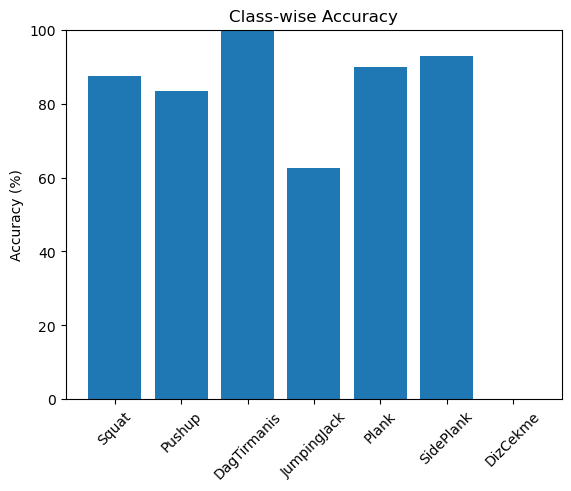

In [22]:
#SONUÇLARI GÖRSELLEŞTİRME
import torch
import numpy as np

model_old_2.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        logits = model_old_2(X)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

from sklearn.metrics import confusion_matrix

num_classes = 7  # senin sınıf sayın
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
print("Confusion Matrix:")
print(cm)

class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Class {i} accuracy: {acc*100:.2f}%")


class_names = [
    "Squat",
    "Pushup",
    "DagTirmanis",
    "JumpingJack",
    #"Lunge",
    "Plank",
    "SidePlank",
    "DizCekme"
]

for name, acc in zip(class_names, class_accuracy):
    print(f"{name}: {acc*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure()
plt.bar(class_names, class_accuracy * 100)
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show()



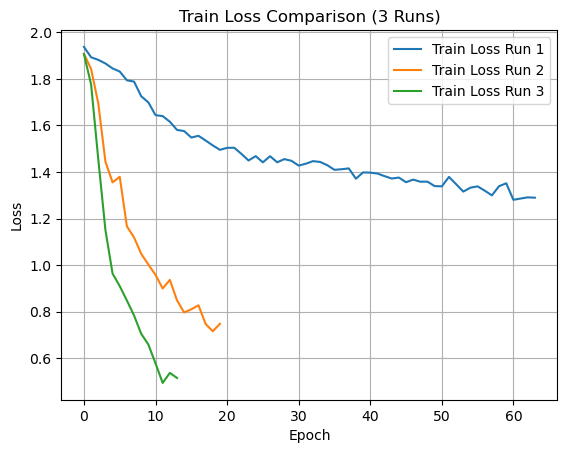

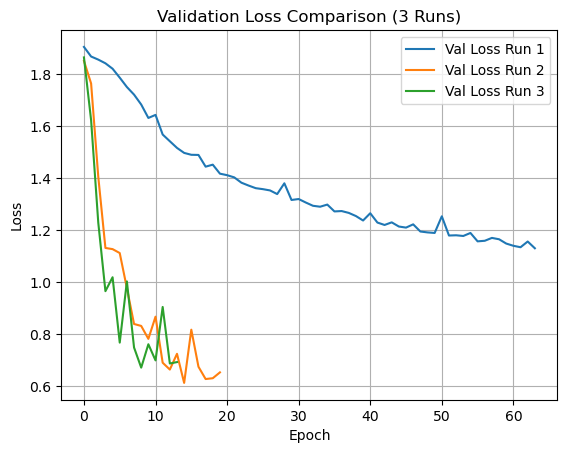

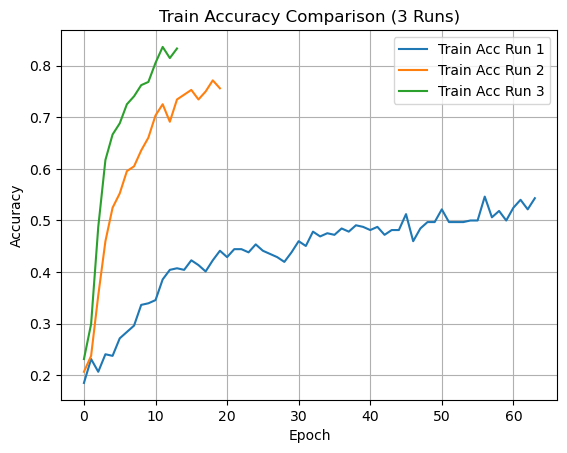

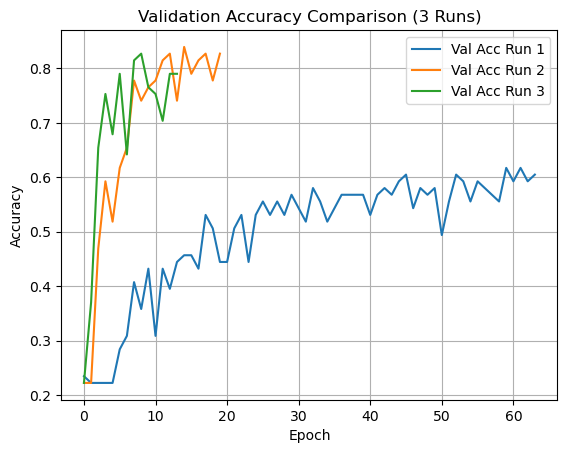

In [23]:
#SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DOSYA SUFFIX'LERİ
# -----------------------
suffixes = ["", "_1", "_2"]

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# -----------------------
# LOAD DATA
# -----------------------
for s in suffixes:
    train_losses.append(np.load(f"before_train_loss{s}.npy"))
    val_losses.append(np.load(f"before_val_loss{s}.npy"))
    train_accs.append(np.load(f"before_train_acc{s}.npy"))
    val_accs.append(np.load(f"before_val_acc{s}.npy"))

# -----------------------
# TRAIN LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(train_losses):
    plt.plot(loss, label=f"Train Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(val_losses):
    plt.plot(loss, label=f"Val Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# TRAIN ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(train_accs):
    plt.plot(acc, label=f"Train Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(val_accs):
    plt.plot(acc, label=f"Val Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
###!!!!!!ONE-HOT EKLENMİŞ ADIM !!!!!

In [24]:
model_new_1 = PoseTCN_2(input_size=107, num_classes=7)

#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

criterion_new_1 = nn.BCEWithLogitsLoss()

optimizer_new_1 = torch.optim.Adam(
    model_new_1.parameters(),
    lr=0.0003,
    weight_decay=1e-4
)

scheduler_new_1 = torch.optim.lr_scheduler.StepLR(
    optimizer_new_1, step_size=15, gamma=0.8
)

new_train_losses_1 , new_train_accs_1 , new_val_losses_1 , new_val_accs_1 =  train_utils.train_multi_class_one_hot(
    model_new_1,
    train_loader,
    test_loader,
    loss=criterion_new_1,
    optimizer=optimizer_new_1,
    scheduler=scheduler_new_1,
    epochs=128,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TCN_One_Hot_NOLunge"
)

np.save("new_train_loss_1.npy", new_train_losses_1)
np.save("new_train_acc_1.npy", new_train_accs_1)
np.save("new_val_loss_1.npy", new_val_losses_1)
np.save("new_val_acc_1.npy", new_val_accs_1)


Epoch [1/128]
Train Loss: 0.4378 | Train Acc: 19.14%
Val   Loss: 0.4606 | Val   Acc: 18.52%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [2/128]
Train Loss: 0.4066 | Train Acc: 21.30%
Val   Loss: 0.4456 | Val   Acc: 25.93%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [3/128]
Train Loss: 0.3943 | Train Acc: 24.69%
Val   Loss: 0.4284 | Val   Acc: 59.26%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [4/128]
Train Loss: 0.3511 | Train Acc: 37.96%
Val   Loss: 0.3487 | Val   Acc: 69.14%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [5/128]
Train Loss: 0.2907 | Train Acc: 56.17%
Val   Loss: 0.3023 | Val   Acc: 79.01%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [6/128]
Train Loss: 0.2481 | Train Acc: 67.28%
Val   Loss: 0.2556 | Val   Acc: 77.78%
LR: 0.000300
----------

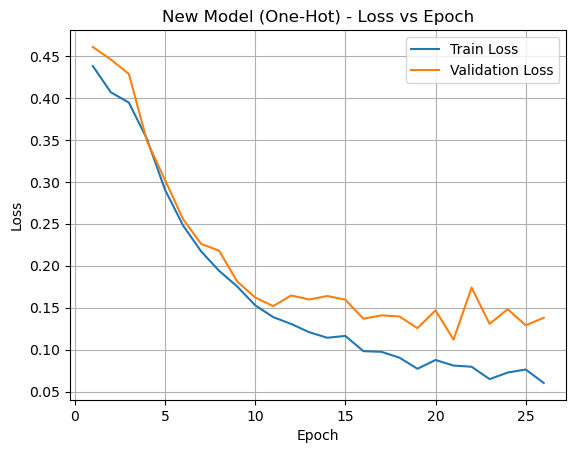

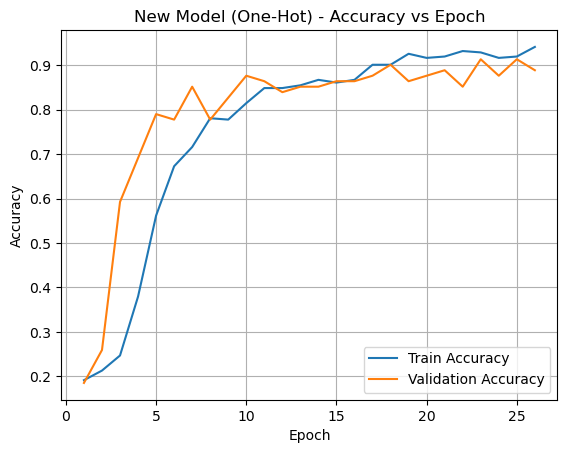

In [25]:
#SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# LOAD DATA
# -----------------------
train_loss = np.load("new_train_loss_1.npy")
val_loss   = np.load("new_val_loss_1.npy")
train_acc  = np.load("new_train_acc_1.npy")
val_acc    = np.load("new_val_acc_1.npy")

epochs = range(1, len(train_loss) + 1)

# -----------------------
# LOSS
# -----------------------
plt.figure()
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("New Model (One-Hot) - Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# ACCURACY
# -----------------------
plt.figure()
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("New Model (One-Hot) - Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix:
[[ 7  0  0  0  1  0  0]
 [ 0 18  0  0  0  0  0]
 [ 0  2 12  1  0  0  0]
 [ 0  0  0  7  0  1  0]
 [ 0  0  0  0  9  1  0]
 [ 0  0  0  0  1 13  0]
 [ 0  0  0  0  0  2  6]]
Squat: 87.50%
Pushup: 100.00%
DagTirmanis: 80.00%
JumpingJack: 87.50%
Plank: 90.00%
SidePlank: 92.86%
DizCekme: 75.00%


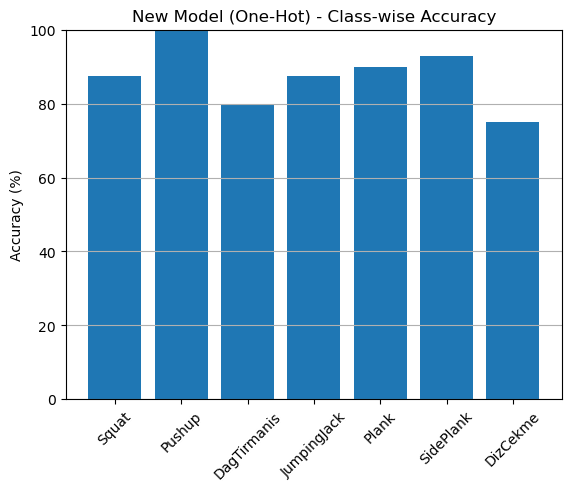

In [26]:
#SONUÇLARI GÖRSELLEŞTİRME

import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model_new_1.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)           # y = integer label (B,)

        logits = model_new_1(X)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


from sklearn.metrics import confusion_matrix

num_classes = 7
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
print("Confusion Matrix:")
print(cm)

class_acc = cm.diagonal() / cm.sum(axis=1)

class_names = [
    "Squat",
    "Pushup",
    "DagTirmanis",
    "JumpingJack",
    #"Lunge",
    "Plank",
    "SidePlank",
    "DizCekme"
]

for name, acc in zip(class_names, class_acc):
    print(f"{name}: {acc*100:.2f}%")

import matplotlib.pyplot as plt

plt.figure()
plt.bar(class_names, class_acc * 100)
plt.ylabel("Accuracy (%)")
plt.title("New Model (One-Hot) - Class-wise Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()



In [27]:
model_new_2 = BiLSTMModel(input_dim=107, hidden_dim=64, num_layers=2, num_classes=7)



criterion_new_2 = nn.BCEWithLogitsLoss()
optimizer_new_2 = torch.optim.Adam(model_new_2.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_2 = torch.optim.lr_scheduler.StepLR(optimizer_new_2, step_size=15, gamma=0.8)

new_train_losses_2 , new_train_accs_2,new_val_losses_2,new_val_accs_2 = train_utils.train_multi_class_one_hot(
    model_new_2,
    train_loader,
    test_loader,
    loss=criterion_new_2,
    optimizer=optimizer_new_2,
    scheduler=scheduler_new_2,
    epochs=50,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="BiLSTM_One_Hot"
)

np.save("new_train_loss_2.npy", new_train_losses_2)
np.save("new_train_acc_2.npy", new_train_accs_2)
np.save("new_val_loss_2.npy", new_val_losses_2)
np.save("new_val_acc_2.npy", new_val_accs_2)



Epoch [1/50]
Train Loss: 0.6643 | Train Acc: 12.04%
Val   Loss: 0.5563 | Val   Acc: 12.35%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [2/50]
Train Loss: 0.4412 | Train Acc: 17.90%
Val   Loss: 0.4033 | Val   Acc: 22.22%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [3/50]
Train Loss: 0.4026 | Train Acc: 23.15%
Val   Loss: 0.4014 | Val   Acc: 22.22%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [4/50]
Train Loss: 0.4020 | Train Acc: 23.15%
Val   Loss: 0.4013 | Val   Acc: 22.22%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [5/50]
Train Loss: 0.4024 | Train Acc: 23.15%
Val   Loss: 0.4012 | Val   Acc: 22.22%
LR: 0.000300
--------------------------------------------------
✅ Best model updated
Epoch [6/50]
Train Loss: 0.4022 | Train Acc: 23.15%
Val   Loss: 0.4012 | Val   Acc: 22.22%
LR: 0.000300
----------------

In [28]:
model_new_3 = BiLSTMModel(input_dim=107, hidden_dim=64, num_layers=2, num_classes=7)



criterion_new_3= nn.CrossEntropyLoss()
optimizer_new_3 = torch.optim.Adam(model_new_3.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_3 = torch.optim.lr_scheduler.StepLR(optimizer_new_3, step_size=15, gamma=0.8)

new_train_losses_3 , new_train_accs_3,new_val_losses_3,new_val_accs_3 = train_utils.train_multi_class_model(
    model_new_3,
    train_loader,
    test_loader,
    loss=criterion_new_3,
    optimizer=optimizer_new_3,
    scheduler=scheduler_new_3,
    epochs=64,
    patience=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="BiLSTM_Model"
)

np.save("new_train_loss_3.npy", new_train_losses_3)
np.save("new_train_acc_3.npy", new_train_accs_3)
np.save("new_val_loss_3.npy", new_val_losses_3)
np.save("new_val_acc_3.npy", new_val_accs_3)



Epoch [1/64]
Train Loss: 1.9357, Train Acc: 16.36%
Val Loss: 1.9152, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/64]
Train Loss: 1.9018, Train Acc: 23.15%
Val Loss: 1.8829, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/64]
Train Loss: 1.8823, Train Acc: 23.15%
Val Loss: 1.8753, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/64]
Train Loss: 1.8737, Train Acc: 23.15%
Val Loss: 1.8592, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/64]
Train Loss: 1.8303, Train Acc: 23.46%
Val Loss: 1.7829, Val Acc: 28.40%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/64]
Train Loss: 1.7245, Train Acc: 29.32%
Val Loss: 1.6927, Val Acc: 29.63%
Learning Rate: 0.000

In [29]:
import torch
import torch.nn as nn

class BiLSTMImproved(nn.Module):
    def __init__(
        self,
        input_dim=102,
        hidden_dim=64,
        num_layers=2,
        num_classes=8,
        dropout=0.3
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # bidirectional olduğu için hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        #x: (batch_size, seq_len, feature_dim)
        out, _ = self.lstm(x)          # (B, T, 2*H)
        # 🔥 Temporal mean pooling
        out = torch.mean(out, dim=1)   # (B, 2*H)
        return self.fc(out)            # (B, num_classes)


In [30]:
model_new_4 = BiLSTMImproved(input_dim=107, hidden_dim=64, num_layers=2, num_classes=7,dropout=0.3)



criterion_new_4= nn.CrossEntropyLoss()
optimizer_new_4 = torch.optim.Adam(model_new_4.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_4 = torch.optim.lr_scheduler.StepLR(optimizer_new_4, step_size=15, gamma=0.8)

new_train_losses_4 , new_train_accs_4,new_val_losses_4,new_val_accs_4 = train_utils.train_multi_class_model(
    model_new_4,
    train_loader,
    test_loader,
    loss=criterion_new_4,
    optimizer=optimizer_new_4,
    scheduler=scheduler_new_4,
    epochs=128,
    patience=6,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="ImprovedBiLSTM_Model"
)

np.save("new_train_loss_4.npy", new_train_losses_4)
np.save("new_train_acc_4.npy", new_train_accs_4)
np.save("new_val_loss_4.npy", new_val_losses_4)
np.save("new_val_acc_4.npy", new_val_accs_4)



Epoch [1/128]
Train Loss: 1.9200, Train Acc: 23.15%
Val Loss: 1.8978, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/128]
Train Loss: 1.8896, Train Acc: 23.15%
Val Loss: 1.8764, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/128]
Train Loss: 1.8745, Train Acc: 23.15%
Val Loss: 1.8615, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/128]
Train Loss: 1.8528, Train Acc: 23.15%
Val Loss: 1.8012, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/128]
Train Loss: 1.7807, Train Acc: 27.78%
Val Loss: 1.6926, Val Acc: 41.98%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/128]
Train Loss: 1.6115, Train Acc: 39.81%
Val Loss: 1.5477, Val Acc: 39.51%
Learning Rate:

In [31]:
model_new_5 = LSTMModel(input_dim=107, hidden_dim=64, num_layers=2, num_classes=7)



criterion_new_5= nn.CrossEntropyLoss()
optimizer_new_5 = torch.optim.Adam(model_new_5.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler_new_5 = torch.optim.lr_scheduler.StepLR(optimizer_new_5, step_size=15, gamma=0.8)

new_train_losses_5 , new_train_accs_5,new_val_losses_5,new_val_accs_5 = train_utils.train_multi_class_model(
    model_new_5,
    train_loader,
    test_loader,
    loss=criterion_new_5,
    optimizer=optimizer_new_5,
    scheduler=scheduler_new_5,
    epochs=64,
    patience=6,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="LSTM_Model"
)

np.save("new_train_loss_5.npy", new_train_losses_5)
np.save("new_train_acc_5.npy", new_train_accs_5)
np.save("new_val_loss_5.npy", new_val_losses_5)
np.save("new_val_acc_5.npy", new_val_accs_5)



Epoch [1/64]
Train Loss: 1.9312, Train Acc: 19.44%
Val Loss: 1.9089, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/64]
Train Loss: 1.8973, Train Acc: 23.15%
Val Loss: 1.8811, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/64]
Train Loss: 1.8881, Train Acc: 23.15%
Val Loss: 1.8805, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/64]
Train Loss: 1.8817, Train Acc: 23.15%
Val Loss: 1.8681, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/64]
Train Loss: 1.8514, Train Acc: 23.15%
Val Loss: 1.8388, Val Acc: 33.33%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/64]
Train Loss: 1.8333, Train Acc: 25.93%
Val Loss: 1.7312, Val Acc: 25.93%
Learning Rate: 0.000

In [ ]:
####!!!!!!!!!!!!!!!!!!#######

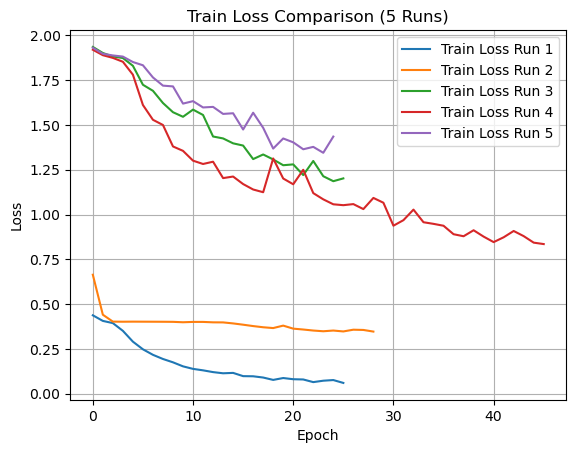

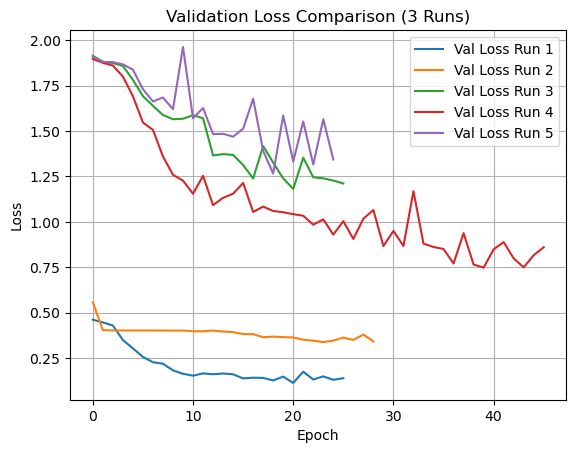

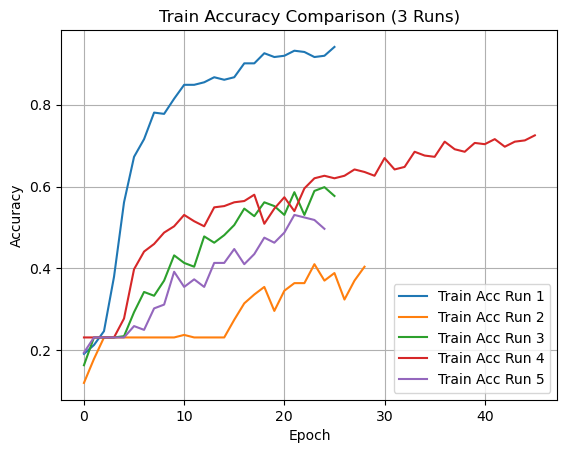

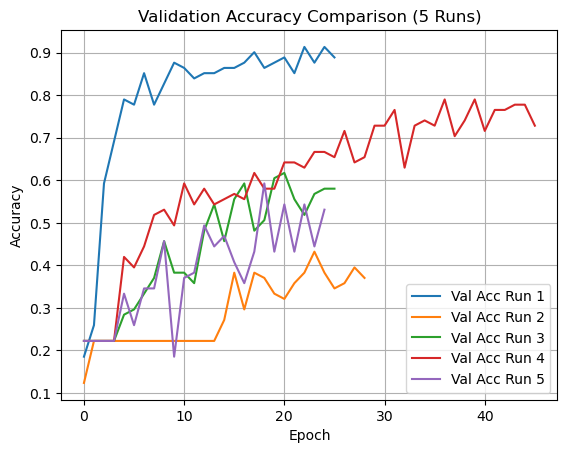

In [32]:

##SONUÇLARI GÖRSELLEŞTİRME
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# DOSYA SUFFIX'LERİ
# -----------------------
suffixes = ["_1", "_2", "_3","_4", "_5"]

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# -----------------------
# LOAD DATA
# -----------------------
for s in suffixes:
    train_losses.append(np.load(f"new_train_loss{s}.npy"))
    val_losses.append(np.load(f"new_val_loss{s}.npy"))
    train_accs.append(np.load(f"new_train_acc{s}.npy"))
    val_accs.append(np.load(f"new_val_acc{s}.npy"))

# -----------------------
# TRAIN LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(train_losses):
    plt.plot(loss, label=f"Train Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss Comparison (5 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION LOSS
# -----------------------
plt.figure()
for i, loss in enumerate(val_losses):
    plt.plot(loss, label=f"Val Loss Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# TRAIN ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(train_accs):
    plt.plot(acc, label=f"Train Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison (3 Runs)")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# VALIDATION ACCURACY
# -----------------------
plt.figure()
for i, acc in enumerate(val_accs):
    plt.plot(acc, label=f"Val Acc Run {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison (5 Runs)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRN(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_model)
        self.gate = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        gate = torch.sigmoid(self.gate(x))
        return self.layer_norm(gate * z + (1 - gate) * x)



class TFT(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_classes):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        self.encoder = nn.LSTM(
            d_model, d_model, batch_first=True
        )

        self.attention = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True
        )

        self.grn = GRN(d_model)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        """
        x: (B, T, F)
        """
        x = self.embedding(x)
        enc_out, _ = self.encoder(x)

        attn_out, _ = self.attention(
            enc_out, enc_out, enc_out
        )

        fused = self.grn(attn_out)

        # (B, T, D) -> (B, D)
        pooled = self.pool(fused.transpose(1, 2)).squeeze(-1)

        logits = self.classifier(pooled)
        return logits


In [34]:
model_transform = TFT(input_dim=107, d_model=64, num_heads=2, num_classes=7)

criterion_tft = nn.CrossEntropyLoss()

optimizer_tft = torch.optim.Adam(
    model_transform.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_tft = torch.optim.lr_scheduler.StepLR(
    optimizer_tft, step_size=15, gamma=0.8
)

train_losses_tft, train_accs_tft, val_losses_tft, val_accs_tft = train_utils.train_multi_class_model(
    model_transform,
    train_loader,
    test_loader,
    loss=criterion_tft,
    optimizer=optimizer_tft,
    scheduler=scheduler_tft,
    epochs=128,
    patience=6,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TFT"
)

np.save("before_train_loss_tft.npy", train_losses_tft)
np.save("before_train_acc_tft.npy", train_accs_tft)
np.save("before_val_loss_tft.npy", val_losses_tft)
np.save("before_val_acc_tft.npy", val_accs_tft)



Epoch [1/128]
Train Loss: 1.9550, Train Acc: 17.90%
Val Loss: 1.8822, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/128]
Train Loss: 1.9024, Train Acc: 20.99%
Val Loss: 1.8726, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/128]
Train Loss: 1.8745, Train Acc: 25.31%
Val Loss: 1.8194, Val Acc: 29.63%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/128]
Train Loss: 1.8205, Train Acc: 26.85%
Val Loss: 1.6950, Val Acc: 25.93%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/128]
Train Loss: 1.6436, Train Acc: 39.81%
Val Loss: 1.4322, Val Acc: 40.74%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/128]
Train Loss: 1.4730, Train Acc: 45.68%
Val Loss: 1.2744, Val Acc: 59.26%
Learning Rate:

In [35]:
class TFT_Classifier_V2(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_classes, dropout=0.2):
        super().__init__()

        self.embedding = nn.Linear(input_dim, d_model)

        # 🔥 CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))

        self.encoder = nn.LSTM(
            d_model, d_model, batch_first=True, dropout=dropout
        )

        self.attn1 = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True, dropout=dropout
        )
        self.grn1 = GRN(d_model)

        self.attn2 = nn.MultiheadAttention(
            d_model, num_heads, batch_first=True, dropout=dropout
        )
        self.grn2 = GRN(d_model)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B, T, _ = x.shape

        x = self.embedding(x)

        # CLS token ekle
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # (B, T+1, D)

        enc_out, _ = self.encoder(x)

        attn_out, _ = self.attn1(enc_out, enc_out, enc_out)
        x = self.grn1(attn_out)

        attn_out, _ = self.attn2(x, x, x)
        x = self.grn2(attn_out)

        cls_out = x[:, 0]  # sadece CLS
        cls_out = self.dropout(cls_out)

        logits = self.classifier(cls_out)
        return logits


In [36]:
model_transform_2 = TFT_Classifier_V2(input_dim=107, d_model=64, num_heads=2, num_classes=7)

criterion_tft_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_tft_2 = torch.optim.Adam(
    model_transform_2.parameters(),
    lr=0.0003,          # 🔥 önemli: 0.001 değil
    weight_decay=1e-4
)

scheduler_tft_2 = torch.optim.lr_scheduler.StepLR(
    optimizer_tft_2, step_size=15, gamma=0.8
)

train_losses_tft_2, train_accs_tft_2, val_losses_tft_2, val_accs_tft_2 = train_utils.train_multi_class_model(
    model_transform_2,
    train_loader,
    test_loader,
    loss=criterion_tft_2,
    optimizer=optimizer_tft_2,
    scheduler=scheduler_tft_2,
    epochs=128,
    patience=6,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="TFT_2"
)

np.save("before_train_loss_tft_2.npy", train_losses_tft_2)
np.save("before_train_acc_tft_2.npy", train_accs_tft_2)
np.save("before_val_loss_tft_2.npy", val_losses_tft_2)
np.save("before_val_acc_tft_2.npy", val_accs_tft_2)



/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [1/128]
Train Loss: 1.9484, Train Acc: 22.22%
Val Loss: 1.9045, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [2/128]
Train Loss: 1.9716, Train Acc: 17.59%
Val Loss: 1.8858, Val Acc: 16.05%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [3/128]
Train Loss: 1.9165, Train Acc: 23.77%
Val Loss: 1.8591, Val Acc: 22.22%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [4/128]
Train Loss: 1.8719, Train Acc: 28.70%
Val Loss: 1.7668, Val Acc: 30.86%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [5/128]
Train Loss: 1.6981, Train Acc: 34.88%
Val Loss: 1.4801, Val Acc: 51.85%
Learning Rate: 0.000300
--------------------------------------------------
Best model updated
Epoch [6/128]
Train Loss: 1.5293, Train Acc: 47.84%
Val Loss: 1.3911, Val Acc: 59.26%
Learning Rate:

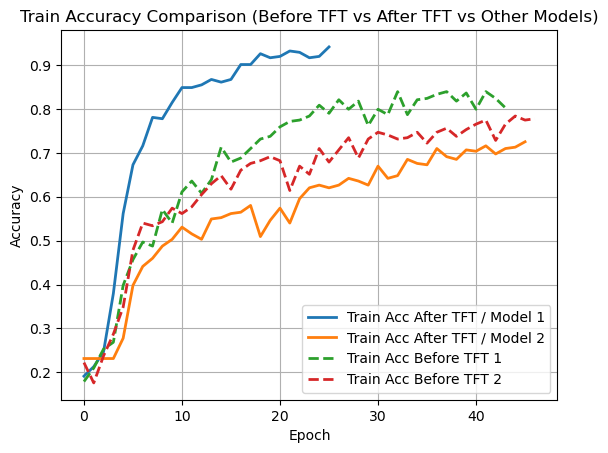

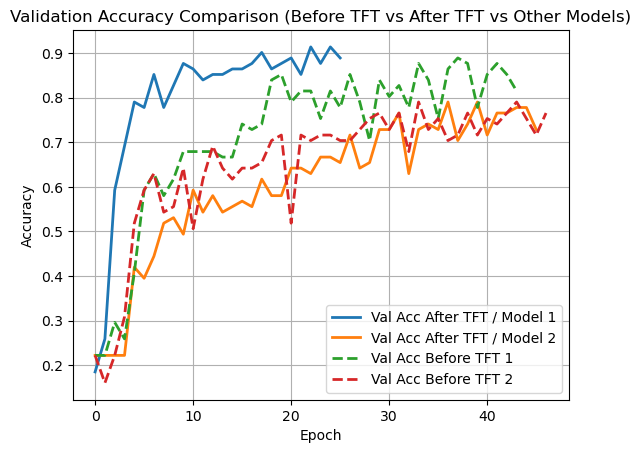

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# AFTER TFT + DİĞER MODELLER
# -----------------------
suffixes = ["_1", "_4"]

train_accs = []
val_accs = []

for s in suffixes:
    train_accs.append(np.load(f"new_train_acc{s}.npy"))
    val_accs.append(np.load(f"new_val_acc{s}.npy"))

# -----------------------
# BEFORE TFT
# -----------------------
before_train_acc_1 = np.load("before_train_acc_tft.npy")
before_train_acc_2 = np.load("before_train_acc_tft_2.npy")

before_val_acc_1 = np.load("before_val_acc_tft.npy")
before_val_acc_2 = np.load("before_val_acc_tft_2.npy")

# ======================================================
# TRAIN ACCURACY (TOPLU)
# ======================================================
plt.figure()

# After TFT / Other models
for i, acc in enumerate(train_accs):
    plt.plot(acc, linewidth=2, label=f"Train Acc After TFT / Model {i+1}")

# Before TFT
plt.plot(before_train_acc_1, linestyle="--", linewidth=2,
         label="Train Acc Before TFT 1")
plt.plot(before_train_acc_2, linestyle="--", linewidth=2,
         label="Train Acc Before TFT 2")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy Comparison (Before TFT vs After TFT vs Other Models)")
plt.legend()
plt.grid(True)
plt.show()

# ======================================================
# VALIDATION ACCURACY (TOPLU)
# ======================================================
plt.figure()

# After TFT / Other models
for i, acc in enumerate(val_accs):
    plt.plot(acc, linewidth=2, label=f"Val Acc After TFT / Model {i+1}")

# Before TFT
plt.plot(before_val_acc_1, linestyle="--", linewidth=2,
         label="Val Acc Before TFT 1")
plt.plot(before_val_acc_2, linestyle="--", linewidth=2,
         label="Val Acc Before TFT 2")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison (Before TFT vs After TFT vs Other Models)")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
from flask import Flask, request, jsonify
import cv2
import numpy as np
import torch
import mediapipe as mp
import os
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

@app.after_request
def after_request(response):
    response.headers.add('Access-Control-Allow-Origin', '*')
    response.headers.add('Access-Control-Allow-Headers', 'Content-Type,Authorization')
    response.headers.add('Access-Control-Allow-Methods', 'GET,PUT,POST,DELETE,OPTIONS')
    return response

@app.route('/')
def home():
    return jsonify({"status": "Flask çalışıyor!", "port": 5001})

class_names = {
    0: "squat",
    1: "pushup",
    2: "dag_tirmanis",
    3: "jumping_jack",
    #4: "lunge",
    4: "plank",
    5: "side_plank",
    6: "diz_cekme"
}

device = "cpu"

MODELS = {
    "tcn": PoseTCN_2(input_size=107, num_classes=7),
    "bilstm": BiLSTMImproved(input_dim=107, hidden_dim=64,num_layers=2 ,num_classes=7),
    "tft_1": TFT(input_dim=107,d_model=64, num_heads=2, num_classes=7),
    "tft_2": TFT_Classifier_V2(input_dim=107,d_model=64,num_heads=2 ,num_classes=7)
}

MODEL_PATHS = {
    "tcn": "/Users/tahay/Documents/Bitirme-KazımHanbay/bitirme0/models/TCN_One_Hot_NOLunge_best.pth",
    "bilstm": "/Users/tahay/Documents/Bitirme-KazımHanbay/bitirme0/models/ImprovedBiLSTM_Model_best.pth",
    "tft_1": "/Users/tahay/Documents/Bitirme-KazımHanbay/bitirme0/models/TFT_best.pth",
    "tft_2": "/Users/tahay/Documents/Bitirme-KazımHanbay/bitirme0/models/TFT_2_best.pth"
}
MODEL_TYPES = {
    "tcn": "one_hot",
    "bilstm": "cross_entropy",
    "tft_1": "cross_entropy",
    "tft_2": "cross_entropy"
}


for name in MODELS:
    MODELS[name].load_state_dict(
        torch.load(MODEL_PATHS[name], map_location=device)
    )
    MODELS[name].eval()


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

sequence_length = 200

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

@app.route('/predict', methods=['POST', 'OPTIONS'])
def predict():
    if request.method == 'OPTIONS':
        return '', 204

    if 'video' not in request.files:
        return jsonify({"error": "Video file missing"}), 400

    video_file = request.files['video']
    video_path = "temp_video.mp4"
    video_file.save(video_path)

    cap = cv2.VideoCapture(video_path)
    frames_data = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            # 🔹 1️⃣ 33 landmark × 3 = 99
            keypoints = []
            for lm in mp_pose.PoseLandmark:
                lm_data = landmarks[lm]
                keypoints.extend([lm_data.x, lm_data.y, lm_data.z])

            # =========================
            # SOL TARAF NOKTALARI
            # =========================
            L_SHOULDER = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
            L_ELBOW    = landmarks[mp_pose.PoseLandmark.LEFT_ELBOW]
            L_WRIST    = landmarks[mp_pose.PoseLandmark.LEFT_WRIST]
            L_HIP      = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
            L_KNEE     = landmarks[mp_pose.PoseLandmark.LEFT_KNEE]
            L_ANKLE    = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE]

            # =========================
            # SAĞ TARAF NOKTALARI
            # =========================
            R_SHOULDER = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
            R_ELBOW    = landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW]
            R_WRIST    = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST]
            R_HIP      = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
            R_KNEE     = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE]
            R_ANKLE    = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE]

            # =========================
            # SOL AÇILAR
            # =========================
            left_shoulder_angle = calculate_angle(
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z]
            )

            left_elbow_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_ELBOW.x, L_ELBOW.y, L_ELBOW.z],
                [L_WRIST.x, L_WRIST.y, L_WRIST.z]
            )

            left_hip_angle = calculate_angle(
                [L_SHOULDER.x, L_SHOULDER.y, L_SHOULDER.z],
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z]
            )

            left_knee_angle = calculate_angle(
                [L_HIP.x, L_HIP.y, L_HIP.z],
                [L_KNEE.x, L_KNEE.y, L_KNEE.z],
                [L_ANKLE.x, L_ANKLE.y, L_ANKLE.z]
            )

            # =========================
            # SAĞ AÇILAR
            # =========================
            right_shoulder_angle = calculate_angle(
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z]
            )

            right_elbow_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_ELBOW.x, R_ELBOW.y, R_ELBOW.z],
                [R_WRIST.x, R_WRIST.y, R_WRIST.z]
            )

            right_hip_angle = calculate_angle(
                [R_SHOULDER.x, R_SHOULDER.y, R_SHOULDER.z],
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z]
            )

            right_knee_angle = calculate_angle(
                [R_HIP.x, R_HIP.y, R_HIP.z],
                [R_KNEE.x, R_KNEE.y, R_KNEE.z],
                [R_ANKLE.x, R_ANKLE.y, R_ANKLE.z]
            )

            # 🔹 Açılar ekleniyor (SOL + SAĞ)
            keypoints.extend([
                left_shoulder_angle, left_elbow_angle, left_hip_angle, left_knee_angle,
                right_shoulder_angle, right_elbow_angle, right_hip_angle, right_knee_angle
            ])

            frames_data.append(keypoints)

    cap.release()
    os.remove(video_path)

    # =====================
    # PAD / TRIM → 200 FRAME
    # =====================
    if len(frames_data) < sequence_length:
        last_frame = frames_data[-1] if frames_data else [0] * 102
        while len(frames_data) < sequence_length:
            frames_data.append(last_frame)

    frames_data = np.array(frames_data[:sequence_length], dtype=np.float32)

    # =====================
    # NORMALIZE (TRAIN İLE AYNI)
    # =====================
    max_val = np.max(np.abs(frames_data))
    if max_val > 0:
        frames_data = frames_data / max_val

    # =====================
    # MODEL INFERENCE
    # =====================
    frames_tensor = torch.from_numpy(frames_data).unsqueeze(0)  # (1, 200, 102)

    model_name = request.form.get("model")
    
    if model_name not in MODELS:
        return jsonify({
            "error": "Invalid model name",
            "available_models": list(MODELS.keys())
        }), 400
    
    model = MODELS[model_name]
    model_type = MODEL_TYPES[model_name]
    
    with torch.no_grad():
        outputs = model(frames_tensor)
    
    # =========================
    # ONE-HOT MODEL (PoseTCN)
    # =========================
    if model_type == "one_hot":
        # sigmoid uygulanmış olabilir ya da olmamış olabilir
        probs = torch.sigmoid(outputs)
        pred_id = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_id].item()
    
    # =========================
    # CROSS ENTROPY MODELLER
    # =========================
    else:
        probs = torch.softmax(outputs, dim=1)
        pred_id = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_id].item()


    return jsonify({
        "selected_model": model_name,
        "prediction_id": pred_id,
        "prediction_name": class_names[pred_id],
        "confidence": round(confidence, 4)
    })




if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5001, debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
I0000 00:00:1766736033.563576 5566009 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://192.168.1.34:5001
Press CTRL+C to quit
W0000 00:00:1766736033.646745 5680874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1766736033.664429 5680874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
127.0.0.1 - - [26/Dec/2025 11:01:19] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2025 11:01:41] "POST /predict HTTP/1.1" 2